# Iteratively Re-weighted Least-Squares Inversion (1D)

In [40]:
import os
import numpy as np
import matplotlib.pyplot as plt

import discretize
from discretize import TensorMesh
    
import SimPEG.electromagnetics.frequency_domain as fdem
from SimPEG.utils import mkvc, plot_1d_layer_model

from SimPEG import (
    maps,
    data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
    utils,
)

import sys
sys.path.append("../")
from inversion_toolkit.model_functions import get_1d_model, generate_survey
from inversion_toolkit.inversion_functions import define_inverse_problem_1DLayered

## Load Data and Plot

In [41]:
# path to the directory containing our data
dir_path = "./3d_simulation_data/"
data_filename = dir_path + "em3dfm_1d_data_1DLayered.txt"

In [42]:
imported_1d_data = np.loadtxt(str(data_filename), skiprows=1)
ntx = int((imported_1d_data.shape[1]-1)/2)

# Define receiver locations and observed data
frequencies = imported_1d_data[:, 0]

In [43]:
x_positions = np.arange(0, 10000, 500)

In [44]:
def get_dobs_from_1d_data(imported_1d_data, location_index):
    dobs_real = imported_1d_data[:, 1::2].T
    dobs_imag = imported_1d_data[:, 2::2].T
    bz_real = dobs_real[location_index]
    bz_imag = dobs_imag[location_index]

    dobs = np.empty(bz_real.size + bz_imag.size, dtype=bz_real.dtype)
    dobs[0::2] = bz_real
    dobs[1::2] = bz_imag
    return dobs

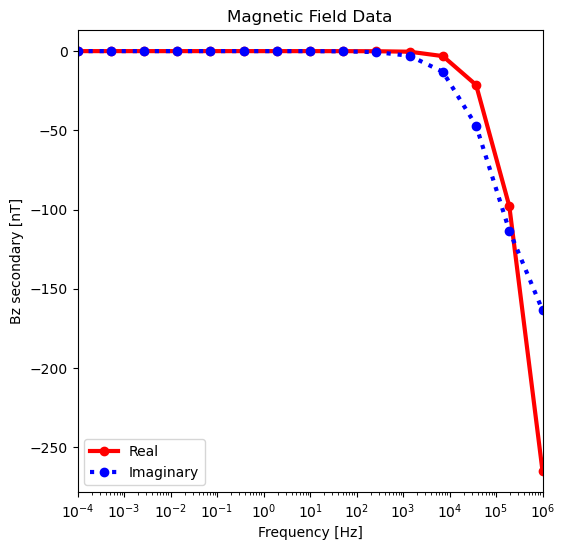

In [45]:
location_index = 0

dobs = get_dobs_from_1d_data(imported_1d_data, location_index)

# Plot FEM response for all frequencies
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.semilogx(frequencies, (10**9)*dobs[0::2], "r-o", lw=3)
ax.semilogx(frequencies, (10**9)*dobs[1::2], "b:o", lw=3)
ax.set_xlim((np.min(frequencies), np.max(frequencies)))
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Bz secondary [nT]")
ax.set_title("Magnetic Field Data")
ax.legend(["Real", "Imaginary"])
plt.show()

In [46]:
survey = generate_survey(frequencies=frequencies, x_position=x_positions[location_index], moment=1)

### Assign Uncertainties

In [47]:
uncertainties = 0.05 * np.abs(dobs) * np.ones(np.shape(dobs))
data_object = data.Data(survey, dobs=dobs, noise_floor=uncertainties)

### Iteratively Re-weighted Least-Squares Inversion

In [48]:
# estimated host conductivity (S/m)
estimated_resistivity = 100

# minimum skin depth
d_min = 500.0 * np.sqrt(estimated_resistivity/ frequencies.max())
print("MINIMUM SKIN DEPTH: {} m".format(d_min))

# maximum skin depth
d_max = 500.0 * np.sqrt(estimated_resistivity/ frequencies.min())
print("MAXIMUM SKIN DEPTH: {} m".format(d_max))

MINIMUM SKIN DEPTH: 5.0 m
MAXIMUM SKIN DEPTH: 500000.0 m


In [49]:
depth_min = 50  # top layer thickness
depth_max = 5000.0  # depth to lowest layer
geometric_factor = 1.1  # rate of thickness increase

In [50]:
# Increase subsequent layer thicknesses by the geometric factors until
# it reaches the maximum layer depth.
layer_thicknesses = [depth_min]
while np.sum(layer_thicknesses) < depth_max:
    layer_thicknesses.append(geometric_factor * layer_thicknesses[-1])

n_layers = len(layer_thicknesses) + 1  # Number of layers
print("n_layers: ", n_layers)

n_layers:  27


In [51]:
log_resistivity_map = maps.ExpMap(nP=n_layers)

In [52]:
# Starting model is log-conductivity values (S/m)
starting_resistivity_model = np.log((estimated_resistivity) * np.ones(n_layers))

# Reference model is also log-resistivity values (S/m)
reference_resistivity_model = starting_resistivity_model.copy()

In [53]:
simulation_irls = fdem.simulation_1d.Simulation1DLayered(
    survey=survey,
    rhoMap=log_resistivity_map,
    thicknesses=layer_thicknesses,
)

### Define Data Misfit

In [54]:
dmis_irls = data_misfit.L2DataMisfit(simulation=simulation_irls, data=data_object)

In [55]:
# Define 1D cell widths
h = np.r_[layer_thicknesses, layer_thicknesses[-1]]
h = np.flipud(h)

# Create regularization mesh
regularization_mesh = TensorMesh([h], "N")
print(regularization_mesh)


  TensorMesh: 27 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     27     -6,000.82          0.00     50.00    541.74    1.10




In [56]:
reg_irls = regularization.Sparse(
    regularization_mesh,
    alpha_s=0.01,
    alpha_x=1,
    reference_model_in_smooth=False,
    norms=[1.0, 1.0],
)

In [57]:
opt_irls = optimization.InexactGaussNewton(
    maxIter=100, maxIterLS=20, maxIterCG=30, tolCG=1e-3
)

In [58]:
inv_prob_irls = inverse_problem.BaseInvProblem(dmis_irls, reg_irls, opt_irls)

In [59]:
starting_beta_irls = directives.BetaEstimate_ByEig(beta0_ratio=1e0)
update_jacobi_irls = directives.UpdatePreconditioner(update_every_iteration=True)
update_irls = directives.Update_IRLS(
    coolingFactor=2,
    coolingRate=3,
    f_min_change=1e-4,
    max_irls_iterations=30,
    chifact_start=1.0,
)

directives_list_irls = [update_irls, starting_beta_irls, update_jacobi_irls]

In [60]:
# Here we combine the inverse problem and the set of directives
inv_irls = inversion.BaseInversion(inv_prob_irls, directives_list_irls)

# Run the inversion
recovered_model_irls = inv_irls.run(starting_resistivity_model)

SimPEG.InvProblem will set Regularization.reference_model to m0.
SimPEG.InvProblem will set Regularization.reference_model to m0.

                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DLayered problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  5.82e+04  2.36e+05  0.00e+00  2.36e+05    3.80e+05      0              
   1  5.82e+04  9.46e+04  9.97e-01  1.53e+05    6.36e+04      0              
   2  5.82e+04  1.15e+05  5.93e-01  1.49e+05    2.74e+04      0              
   3  2.91e+04  1.06e+05  7.38e-01  1.27e+05    7.30e+04      0              
   4  2.91e+04  7.21e+04  1.69e+00  1.21e+05    2.39e+04   

In [61]:
dpred_irls = simulation_irls.dpred(recovered_model_irls)

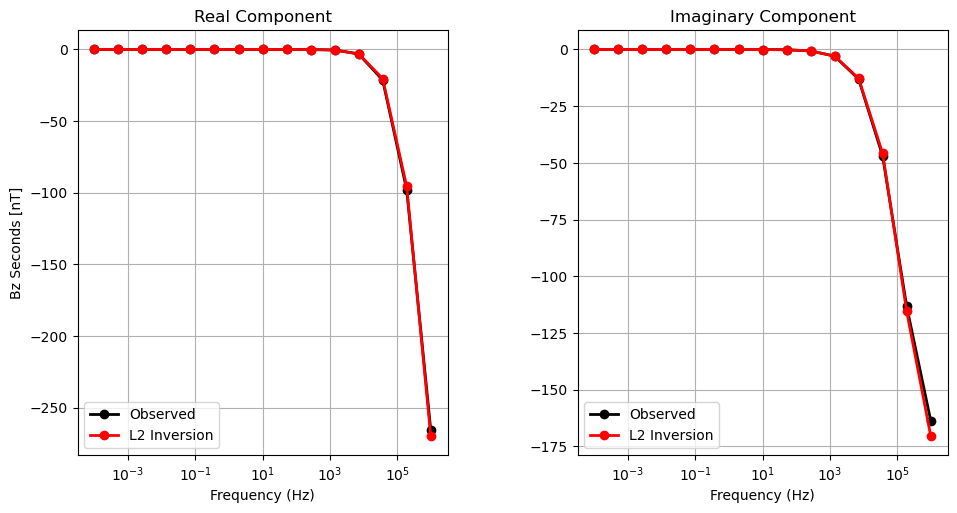

In [62]:
fig = plt.figure(figsize=(10, 5))
ax = [fig.add_axes([0.1 + ii * 0.5, 0.1, 0.37, 0.85]) for ii in range(2)]
for ii in range(2):
    ax[ii].semilogx(frequencies, (10**9) *(dobs[ii::2]), "k-o", lw=2)
    ax[ii].semilogx(frequencies, (10**9) *(dpred_irls[ii::2]), "r-o", lw=2)
    ax[ii].grid(which="both")
    ax[ii].set_xlabel("Frequency (Hz)")
    ax[ii].set_ylabel("Bz Seconds [nT]")
    ax[ii].legend(["Observed", "L2 Inversion"])
    if ii == 1:
        ax[ii].set_ylabel("")

ax[0].set_title("Real Component")
ax[1].set_title("Imaginary Component")
plt.show()

In [63]:
m_true = np.load("../models/2d-model-array.npy")
inversion_mesh_2d = discretize.load_mesh("../meshes/inversion_mesh_2d.json")
true_layers,true_log_resistivity_map, true_log_resistivities,_ = get_1d_model(x_positions[location_index],
                                                                              m_true, 
                                                                              inversion_mesh_2d
                                                                              )
true_resistivities = true_log_resistivity_map*true_log_resistivities

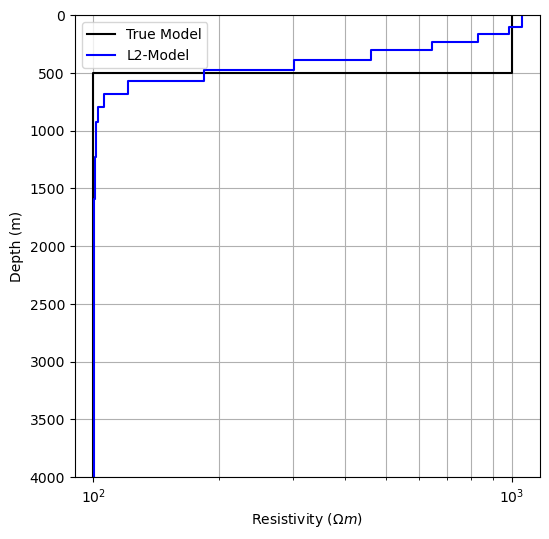

In [64]:
fig, ax = plt.subplots(1,1, figsize=(6, 6))

plot_1d_layer_model(true_layers, true_resistivities, ax=ax, color="k")
plot_1d_layer_model(layer_thicknesses, log_resistivity_map * recovered_model_irls, ax=ax, color="b")
ax.grid(which="both")
ax.set_xlabel(r"Resistivity ($\Omega m$)")
x_min, x_max = true_resistivities.min(), true_resistivities.max()
ax.set_ylim([4000, 0])
# ax.set_xlim(0.5 * x_min, 1.5 * x_max)
ax.legend(["True Model", "L2-Model"])
plt.show()